# AI Career Accelerator - Kawthar Shaalan

## Project Goal:
Build a machine learning model that predicts whether a passenger survived the Titanic disaster based on features such as age, sex, ticket class, and more.

In [66]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix


In [40]:
# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

load the training data

In [41]:
train_data = pd.read_csv('train.csv')
test_data= pd.read_csv('test.csv')

understanding what we are working with 

In [42]:
print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Training data shape: (891, 12)
Test data shape: (418, 11)


displaying the first few rows 

In [43]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Exploring Data Analysis EDA

In [44]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [45]:
print(train_data.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [46]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Relationships visualization 

In [47]:
plt.figure(figsize =(12, 8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

Survival rate by gender 

Text(0.5, 1.0, 'Survival by Gender')

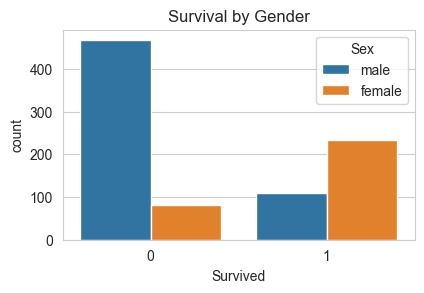

In [48]:
plt.subplot(2,2,1)
sns.countplot(x='Survived', hue='Sex', data=train_data)
plt.title('Survival by Gender')


Survival rate by class

Text(0.5, 1.0, 'Survival by Class')

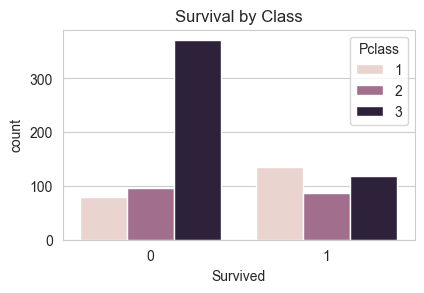

In [49]:
plt.subplot(2,2,2)
sns.countplot(x='Survived', hue='Pclass', data=train_data)
plt.title('Survival by Class')

Age distribution of survivors vs non-survivors 

Text(0.5, 1.0, 'Survival by Age')

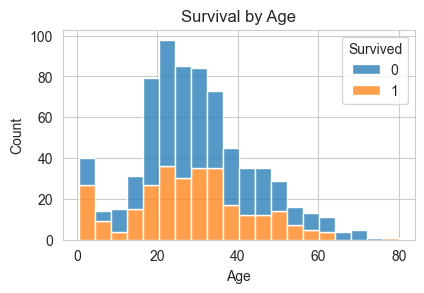

In [50]:
plt.subplot(2,2,3)
sns.histplot(data=train_data, x='Age', hue='Survived', multiple='stack')
plt.title('Survival by Age')

Survival rate by embarktion port 

Text(0.5, 1.0, 'Survival by Embarkation Port')

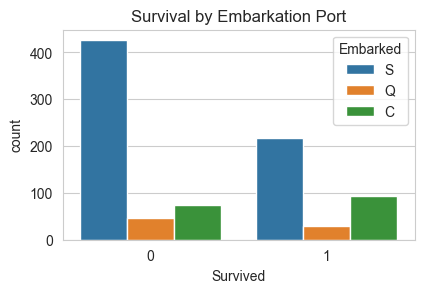

In [51]:
plt.subplot(2, 2, 4)
sns.countplot(x='Survived', hue='Embarked', data=train_data)
plt.title('Survival by Embarkation Port')

## Data Processing 

In [52]:
def preprocess_data(df):
    df_clean = df.copy()  ## to avoid modifying the original data 
    df_clean['Age'].fillna(df_clean['Age'].median(), inplace= True) ## fill with median age 
    df_clean['Embarked'].fillna(df_clean['Embarked'].mode()[0], inplace =True) ## fill with the most common value 
    df_clean['Fare'].fillna(df_clean['Fare'].median(), inplace= True) ## fill with medain value

    ## Feature Engineering 
    df_clean['FamilySize'] = df_clean['SibSp'] + df_clean['Parch'] + 1 ## family size
    df_clean['isALone'] = (df_clean['FamilySize'] == 1).astype(int) ## is alone ?

    ## age grouping 
    df_clean['AgeGroup'] = pd.cut(df_clean['Age'], 
                            bins=[0, 12, 18, 35, 60, 100], 
                            labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])
    
    label_encoders = {}


    ## LabelEncoder() converts text into numbers 
    le_sex = LabelEncoder() 
    df_clean['Sex'] = le_sex.fit_transform(df_clean['Sex'])
    label_encoders['Sex'] = le_sex

    le_embarked = LabelEncoder() 
    df_clean['Embarked'] = le_embarked.fit_transform(df_clean['Embarked'].astype(str))
    label_encoders['Embarked'] = le_embarked

    le_agegroup = LabelEncoder()
    df_clean['AgeGroup'] = le_agegroup.fit_transform(df_clean['AgeGroup'])
    label_encoders['AgeGroup'] = le_agegroup

    return df_clean, label_encoders

train_clean, train_label_encoders = preprocess_data(train_data)
test_clean, test_label_encoders = preprocess_data(test_data)





C:\Users\user\AppData\Local\Temp\ipykernel_27404\2323041761.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['Age'].fillna(df_clean['Age'].median(), inplace= True) ## fill with median age
C:\Users\user\AppData\Local\Temp\ipykernel_27404\2323041761.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting valu

## Feature Selection 

In [53]:
features_to_train = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'isALone']

# prepare the training data 
X = train_clean[features_to_train]
y = train_clean['Survived']

X_test = test_clean[features_to_train]

print(f"Training features shape: {X.shape}")
print(f"Test features shape: {X_test.shape}")

Training features shape: (891, 9)
Test features shape: (418, 9)


## Model Building & Evaluation

In [54]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state= 42)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")


Training set: (712, 9)
Validation set: (179, 9)


Initialization of the random forest model 

In [55]:
model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


make predictions 

In [56]:
y_pred = model.predict(X_val)

evaluate the model accurecy 

In [58]:
rf_acc = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {rf_acc:.4f}")

Validation Accuracy: 0.7989


In [59]:
print("\nDetailed Classification Report:")
print(classification_report(y_val, y_pred))


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       105
           1       0.80      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



Initilaization of the logistic regression model 

In [60]:
logistic_model = LogisticRegression(
    random_state=42,    # For reproducible results
    max_iter=1000       # Increase iterations for convergence
)

In [61]:
from sklearn.model_selection import train_test_split

# Split data: 80% training, 20% validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,  # For reproducible split
    stratify=y        # Maintain same survival ratio in both sets
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Survival rate in training: {y_train.mean():.2f}")
print(f"Survival rate in validation: {y_val.mean():.2f}")

Training set: 712 samples
Validation set: 179 samples
Survival rate in training: 0.38
Survival rate in validation: 0.39


fitting

In [62]:
logistic_model.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [63]:
y_pred = logistic_model.predict(X_val)
y_pred_proba = logistic_model.predict_proba(X_val)  # Probability scores

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [67]:
accuracy = accuracy_score(y_val, y_pred)
print(f" Validation Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Detailed classification report
print("\n Detailed Classification Report:")
print(classification_report(y_val, y_pred))

# Confusion matrix
print(" Confusion Matrix:")
cm = confusion_matrix(y_val, y_pred)
print(cm)

 Validation Accuracy: 0.8101 (81.01%)

 Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       110
           1       0.80      0.68      0.73        69

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179

 Confusion Matrix:
[[98 12]
 [22 47]]


Initialization of xgb model 

In [68]:
xgb_model = xgb.XGBClassifier(
    random_state=42,        # For reproducible results
    n_estimators=100,       # Number of trees
    max_depth=3,            # Maximum tree depth
    learning_rate=0.1,      # How quickly model learns
    eval_metric='logloss',  # Evaluation metric for binary classification
    subsample=0.8,          # Use 80% of data for each tree
    colsample_bytree=0.8    # Use 80% of features for each tree
)

In [69]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Maintain same survival ratio
)

fitting

In [70]:
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],  # Evaluate on validation set during training
    verbose=False               # Set to True if you want to see training progress
)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [71]:
y_pred = xgb_model.predict(X_val)
y_pred_proba = xgb_model.predict_proba(X_val)

In [72]:
# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"\n XGBoost Validation Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Detailed classification report
print("\n Detailed Classification Report:")
print(classification_report(y_val, y_pred))

# Confusion matrix
print(" Confusion Matrix:")
cm = confusion_matrix(y_val, y_pred)
print(cm)


 XGBoost Validation Accuracy: 0.7989 (79.89%)

 Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       110
           1       0.80      0.64      0.71        69

    accuracy                           0.80       179
   macro avg       0.80      0.77      0.78       179
weighted avg       0.80      0.80      0.79       179

 Confusion Matrix:
[[99 11]
 [25 44]]


Cross - Validation for Model Robustness

In [73]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [74]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss')
}

In [75]:
## use stratified k-fold for better representation of classes 
cv = StratifiedKFold(n_splits= 5, shuffle= True, random_state=42)
cv_results= {}

results of the models 

In [76]:
for name, model in models.items():
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring= 'accuracy')
    cv_results[name] ={
        'mean_accuracy': cv_scores.mean(),
        'std_accuracy': cv_scores.std(),
        'all_scores': cv_scores,
        'min_score': cv_scores.min(),
        'max_score': cv_scores.max()
    }
    print(f"{name:20} | Mean CV: {cv_scores.mean():.4f} (±{cv_scores.std()*2:.4f})")
    print(f"{' ':20} | Fold scores: {[f'{s:.4f}' for s in cv_scores]}")

Logistic Regression  | Mean CV: 0.7991 (±0.0339)
                     | Fold scores: ['0.7821', '0.7978', '0.7921', '0.7921', '0.8315']
Random Forest        | Mean CV: 0.8182 (±0.0534)
                     | Fold scores: ['0.8156', '0.8090', '0.7753', '0.8371', '0.8539']
XGBoost              | Mean CV: 0.8182 (±0.0521)
                     | Fold scores: ['0.8268', '0.8427', '0.7697', '0.8146', '0.8371']


In [77]:
# Find best model
best_model_name = max(cv_results, key=lambda x: cv_results[x]['mean_accuracy'])
best_score = cv_results[best_model_name]['mean_accuracy']

print(f" BEST MODEL: {best_model_name} (Mean CV Accuracy: {best_score:.4f})")

 BEST MODEL: Random Forest (Mean CV Accuracy: 0.8182)


## Hyperparameter tuning using GridSearchCV

In [78]:
from sklearn.model_selection import GridSearchCV


In [87]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']  
}

In [88]:
# Create GridSearchCV
grid_search_simple = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,           ## 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,      ## use all processors
    verbose=1       ## show progress
)


In [89]:
grid_search_simple.fit(X_train, y_train)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [5, 10, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,300


In [90]:
print(f" Best parameters: {grid_search_simple.best_params_}")
print(f" Best cross-validation score: {grid_search_simple.best_score_:.4f}")

 Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
 Best cross-validation score: 0.8217


In [91]:
original_score = rf_acc

In [92]:
tuned_model = grid_search_simple.best_estimator_
tuned_score = tuned_model.score(X_val, y_val)

In [94]:
print(f"Original Random Forest: {original_score:.4f} ({original_score*100:.2f}%)")
print(f"Tuned Random Forest:    {tuned_score:.4f} ({tuned_score*100:.2f}%)")

improvement = tuned_score - original_score
print(f"Improvement: {improvement:+.4f} ({improvement*100:+.2f}%)")

Original Random Forest: 0.7989 (79.89%)
Tuned Random Forest:    0.7989 (79.89%)
Improvement: +0.0000 (+0.00%)


No improvement 